


# INIT PART #
This part is just for connecting to hopsworks and downloading the dependicies needed. 

For the connecting to hopsworks we use the config file from Lab1 - somewhat moderized since we only need Hopsworks and not logging into Aqin. The config file uses our .env file that holds our respective hopsworks key.





In [30]:
import sys
from pathlib import Path
import os

root_dir = Path.cwd().parent   # ← one directory up
root_dir = str(root_dir)
print("Local environment")

# Add the root directory to the `PYTHONPATH` to use the `recsys` Python module from the notebook.
if root_dir not in sys.path:
    sys.path.append(root_dir)
print(f"Added the following directory to the PYTHONPATH: {root_dir}")
    
# Set the environment variables from the file <root_dir>/.env
import config
if os.path.exists(f"{root_dir}/.env"):
    settings = config.HopsworksSettings(_env_file=f"{root_dir}/.env")


Local environment
Added the following directory to the PYTHONPATH: /Users/annastegaras/Desktop/ID2223/project/ML_Scale_Project
HopsworksSettings initialized!


In [31]:
import hopsworks
# Check if HOPSWORKS_API_KEY env variable is set or if it is set in ~/.env
if settings.HOPSWORKS_API_KEY is not None:
    api_key = settings.HOPSWORKS_API_KEY.get_secret_value()
    os.environ['HOPSWORKS_API_KEY'] = api_key
project = hopsworks.login()
fs = project.get_feature_store() 

2026-01-08 15:25:31,996 INFO: Closing external client and cleaning up certificates.
Connection closed.
2026-01-08 15:25:32,003 INFO: Initializing external client
2026-01-08 15:25:32,004 INFO: Base URL: https://c.app.hopsworks.ai:443
2026-01-08 15:25:33,552 INFO: Python Engine initialized.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/1286325


In [32]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from xgboost import plot_importance
from sklearn.metrics import mean_squared_error, r2_score
import hopsworks

import warnings
warnings.filterwarnings("ignore")





# CREATING THE FEATURE VIEW #
The following part loads our three feature groups and the joins them in the feature view "stockholm_merged_fv", where total-landings will be the target label. All groups include date which will be used when joining so each column in each row correspond to the intended date. 





In [33]:
# Retrieve feature groups
flight_arlanda_fg = fs.get_feature_group(
    name='flight_data_arlanda',
    version=1,
)

google_trends_fg = fs.get_feature_group(
    name='google_trends_daily',
    version=1,
)

In [34]:
# Select features for training data.
selected_features_naive = (
    flight_arlanda_fg
        .select(['date','total_landings'])
        .join(google_trends_fg.select_features(), on=['city'])
)


feature_view = fs.get_or_create_feature_view(
    name='flight_google_fv',
    description="Using information from google trends to predict flights to sweden",
    version=1,
    labels=['total_landings'],
    query=selected_features_naive,
)

2026-01-08 15:25:39,285 INFO: Using ['vikings', 'fika', 'stockholm', 'ikea', 'abba', 'vikings_7d_avg', 'fika_7d_avg', 'stockholm_7d_avg', 'ikea_7d_avg', 'abba_7d_avg'] from feature group `google_trends_daily` as features for the query. To include primary key and event time use `select_all`.






# RETRIEVING THE TRAINING DATA IN "RAW" FORMAT #
In this section we use train_test_split() from Hopsworks to split the data, and then we do a sanity check with just wrighting X_train to see that the data we have retrived is correct. 





In [49]:
X_train, X_test, y_train, y_test = feature_view.train_test_split(
    test_start="2024-12-30"
)

Finished: Reading data from Hopsworks, using Hopsworks Feature Query Service (1.73s) 
2026-01-08 15:30:00,132 INFO: Provenance cached data - overwriting last accessed/created training dataset from 2 to 3.


In [50]:
X_train

,date,vikings,fika,stockholm,ikea,abba,vikings_7d_avg,fika_7d_avg,stockholm_7d_avg,ikea_7d_avg,abba_7d_avg
0,2020-01-07 00:00:00+00:00,3.0,1.0,95.0,48.0,1.0,2.857143,1.0,84.714286,63.857143,1.571429
1,2020-01-08 00:00:00+00:00,3.0,1.0,89.0,45.0,1.0,3.142857,1.0,87.000000,65.142857,1.142857
2,2020-01-09 00:00:00+00:00,3.0,1.0,88.0,47.0,1.0,3.142857,1.0,87.571429,62.714286,1.000000
3,2020-01-10 00:00:00+00:00,3.0,1.0,83.0,42.0,1.0,3.142857,1.0,87.000000,60.571429,1.000000
4,2020-01-11 00:00:00+00:00,4.0,1.0,83.0,62.0,1.0,3.142857,1.0,86.000000,58.142857,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
2043,2020-01-02 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2044,2020-01-03 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2045,2020-01-04 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2046,2020-01-05 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [51]:
y_train

,total_landings
0,268.0
1,276.0
2,274.0
3,143.0
4,232.0
...,...
2043,234.0
2044,166.0
2045,241.0
2046,272.0






# DATA CLEANING AND FEATURE ENGINEERING 
In this section we will remove NAN values, we will also insert some new features based on the raw data. Because of this we only save raw data to feature groups and we do the feature engineering of adding for example lagging values and delta values for google trends here.





In [52]:
# 1. Checking the amount of rows containing NAN values
# The reason behind this is because our google prefill includes average values from the last 7 days 

nan_mask = X_train.isna().any(axis=1)
nan_mask.sum()   # how many bad rows

7

In [53]:
# 2. We then remove these values from both X_train and y_train to assure correctness 

X_train = X_train.loc[~nan_mask].reset_index(drop=True)
y_train = y_train.loc[~nan_mask].reset_index(drop=True)

In [54]:
# 3. Sanity check to see that both X_train and y_train has the same amount of rows 
print(X_train.info())
print(y_train.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   date              1816 non-null   object 
 1   vikings           1816 non-null   float64
 2   fika              1816 non-null   float64
 3   stockholm         1816 non-null   float64
 4   ikea              1816 non-null   float64
 5   abba              1816 non-null   float64
 6   vikings_7d_avg    1816 non-null   float64
 7   fika_7d_avg       1816 non-null   float64
 8   stockholm_7d_avg  1816 non-null   float64
 9   ikea_7d_avg       1816 non-null   float64
 10  abba_7d_avg       1816 non-null   float64
dtypes: float64(10), object(1)
memory usage: 156.2+ KB
None
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816 entries, 0 to 1815
Data columns (total 1 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   total_landings  1816 

In [55]:
X_train

,date,vikings,fika,stockholm,ikea,abba,vikings_7d_avg,fika_7d_avg,stockholm_7d_avg,ikea_7d_avg,abba_7d_avg
0,2020-01-07 00:00:00+00:00,3.0,1.0,95.0,48.0,1.0,2.857143,1.000000,84.714286,63.857143,1.571429
1,2020-01-08 00:00:00+00:00,3.0,1.0,89.0,45.0,1.0,3.142857,1.000000,87.000000,65.142857,1.142857
2,2020-01-09 00:00:00+00:00,3.0,1.0,88.0,47.0,1.0,3.142857,1.000000,87.571429,62.714286,1.000000
3,2020-01-10 00:00:00+00:00,3.0,1.0,83.0,42.0,1.0,3.142857,1.000000,87.000000,60.571429,1.000000
4,2020-01-11 00:00:00+00:00,4.0,1.0,83.0,62.0,1.0,3.142857,1.000000,86.000000,58.142857,1.000000
...,...,...,...,...,...,...,...,...,...,...,...
1811,2024-12-25 00:00:00+00:00,1.0,1.0,76.0,56.0,2.0,0.857143,2.285714,78.571429,40.000000,1.571429
1812,2024-12-26 00:00:00+00:00,1.0,1.0,83.0,61.0,1.0,0.857143,2.142857,77.571429,43.000000,1.714286
1813,2024-12-27 00:00:00+00:00,1.0,2.0,85.0,54.0,1.0,0.857143,2.000000,78.000000,46.857143,1.571429
1814,2024-12-28 00:00:00+00:00,1.0,2.0,80.0,63.0,1.0,0.857143,2.000000,78.857143,49.714286,1.571429


In [56]:
X_test

,date,vikings,fika,stockholm,ikea,abba,vikings_7d_avg,fika_7d_avg,stockholm_7d_avg,ikea_7d_avg,abba_7d_avg
1816,2024-12-30 00:00:00+00:00,1.0,2.0,86.0,54.0,1.0,0.857143,1.714286,78.714286,52.285714,1.285714
1817,2024-12-31 00:00:00+00:00,1.0,2.0,77.0,33.0,5.0,0.857143,1.571429,79.857143,54.857143,1.142857
1818,2025-01-01 00:00:00+00:00,1.0,1.0,88.0,51.0,2.0,1.000000,1.714286,81.285714,54.857143,1.714286
1819,2025-01-02 00:00:00+00:00,1.0,2.0,88.0,59.0,1.0,1.000000,1.714286,83.000000,54.142857,1.714286
1820,2025-01-03 00:00:00+00:00,1.0,1.0,88.0,53.0,1.0,1.000000,1.857143,83.714286,53.857143,1.714286
...,...,...,...,...,...,...,...,...,...,...,...
2181,2025-12-23 00:00:00+00:00,1.0,3.0,75.0,34.0,1.0,1.142857,2.571429,84.571429,42.571429,1.571429
2182,2025-12-24 00:00:00+00:00,1.0,1.0,67.0,33.0,2.0,1.142857,2.714286,84.000000,42.428571,1.571429
2183,2025-12-25 00:00:00+00:00,1.0,1.0,83.0,56.0,1.0,1.000000,2.571429,81.857143,41.714286,1.714286
2184,2025-12-26 00:00:00+00:00,1.0,2.0,85.0,62.0,1.0,1.000000,2.428571,81.142857,44.714286,1.714286


In [57]:
X_train['lag_1'] = y_train['total_landings'].shift(1)
X_train['lag_7'] = y_train['total_landings'].shift(7)
X_train['rolling_7'] = y_train['total_landings'].shift(1).rolling(7).mean()

nan_mask = X_train.isna().any(axis=1)
nan_mask.sum()   # how many bad rows

X_train = X_train.loc[~nan_mask].reset_index(drop=True)
y_train = y_train.loc[~nan_mask].reset_index(drop=True)

X_train

,date,vikings,fika,stockholm,ikea,abba,vikings_7d_avg,fika_7d_avg,stockholm_7d_avg,ikea_7d_avg,abba_7d_avg,lag_1,lag_7,rolling_7
0,2020-01-14 00:00:00+00:00,3.0,1.0,98.0,41.0,1.0,3.285714,1.000000,89.285714,50.428571,1.000000,264.0,268.0,249.000000
1,2020-01-15 00:00:00+00:00,3.0,1.0,94.0,43.0,1.0,3.285714,1.000000,89.714286,49.428571,1.000000,271.0,276.0,249.428571
2,2020-01-16 00:00:00+00:00,3.0,1.0,94.0,42.0,1.0,3.285714,1.000000,90.428571,49.142857,1.000000,276.0,274.0,249.428571
3,2020-01-17 00:00:00+00:00,3.0,1.0,80.0,41.0,1.0,3.285714,1.000000,91.285714,48.428571,1.000000,284.0,143.0,250.857143
4,2020-01-18 00:00:00+00:00,4.0,1.0,90.0,67.0,2.0,3.285714,1.000000,90.857143,48.285714,1.000000,138.0,232.0,250.142857
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1804,2024-12-25 00:00:00+00:00,1.0,1.0,76.0,56.0,2.0,0.857143,2.285714,78.571429,40.000000,1.571429,109.0,237.0,175.857143
1805,2024-12-26 00:00:00+00:00,1.0,1.0,83.0,61.0,1.0,0.857143,2.142857,77.571429,43.000000,1.714286,180.0,218.0,167.714286
1806,2024-12-27 00:00:00+00:00,1.0,2.0,85.0,54.0,1.0,0.857143,2.000000,78.000000,46.857143,1.571429,192.0,159.0,164.000000
1807,2024-12-28 00:00:00+00:00,1.0,2.0,80.0,63.0,1.0,0.857143,2.000000,78.857143,49.714286,1.571429,146.0,213.0,162.142857


In [58]:
X_test['lag_1'] = y_test['total_landings'].shift(1)
X_test['lag_7'] = y_test['total_landings'].shift(7)
X_test['rolling_7'] = y_test['total_landings'].shift(1).rolling(7).mean()

nan_mask = X_test.isna().any(axis=1)
nan_mask.sum()   # how many bad rows

X_test = X_test.loc[~nan_mask].reset_index(drop=True)
y_test = y_test.loc[~nan_mask].reset_index(drop=True)

X_test

,date,vikings,fika,stockholm,ikea,abba,vikings_7d_avg,fika_7d_avg,stockholm_7d_avg,ikea_7d_avg,abba_7d_avg,lag_1,lag_7,rolling_7
0,2025-01-06 00:00:00+00:00,1.0,2.0,86.0,64.0,2.0,1.000000,1.714286,86.142857,54.857143,1.857143,211.0,123.0,180.571429
1,2025-01-07 00:00:00+00:00,1.0,1.0,91.0,43.0,1.0,1.000000,1.714286,86.142857,56.285714,2.000000,200.0,150.0,191.571429
2,2025-01-08 00:00:00+00:00,1.0,1.0,82.0,40.0,1.0,1.000000,1.571429,88.142857,57.714286,1.428571,173.0,213.0,194.857143
3,2025-01-09 00:00:00+00:00,1.0,1.0,82.0,37.0,1.0,1.000000,1.571429,87.285714,56.142857,1.285714,201.0,209.0,193.142857
4,2025-01-10 00:00:00+00:00,1.0,2.0,82.0,36.0,2.0,1.000000,1.428571,86.428571,53.000000,1.285714,208.0,159.0,193.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
351,2025-12-23 00:00:00+00:00,1.0,3.0,75.0,34.0,1.0,1.142857,2.571429,84.571429,42.571429,1.571429,238.0,232.0,249.142857
352,2025-12-24 00:00:00+00:00,1.0,1.0,67.0,33.0,2.0,1.142857,2.714286,84.000000,42.428571,1.571429,119.0,273.0,233.000000
353,2025-12-25 00:00:00+00:00,1.0,1.0,83.0,56.0,1.0,1.000000,2.571429,81.857143,41.714286,1.714286,139.0,287.0,213.857143
354,2025-12-26 00:00:00+00:00,1.0,2.0,85.0,62.0,1.0,1.000000,2.428571,81.142857,44.714286,1.714286,229.0,193.0,205.571429


In [59]:
y_train

,total_landings
0,271.0
1,276.0
2,284.0
3,138.0
4,229.0
...,...
1804,180.0
1805,192.0
1806,146.0
1807,202.0


In [60]:
X_features = X_train.drop(columns=['date','vikings_7d_avg','fika_7d_avg','stockholm_7d_avg','ikea_7d_avg','abba_7d_avg'])
X_test_features = X_test.drop(columns=['date','vikings_7d_avg','fika_7d_avg','stockholm_7d_avg','ikea_7d_avg','abba_7d_avg'])

# MODELING 

In [61]:
# Creating an instance of the XGBoost Regressor
xgb_regressor = XGBRegressor()

# Fitting the XGBoost Regressor to the training data
xgb_regressor.fit(X_features, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [62]:
# Predicting target values on the test set
y_pred = xgb_regressor.predict(X_test_features)

# Calculating Mean Squared Error (MSE) using sklearn
mse = mean_squared_error(y_test.iloc[:,0], y_pred)
print("MSE:", mse)

# Calculating R squared using sklearn
r2 = r2_score(y_test.iloc[:,0], y_pred)
print("R squared:", r2)

MSE: 7596.623
R squared: -2.5573991943504693


In [63]:
df = y_test
df['predicted_landings'] = y_pred

In [64]:
df['date'] = X_test['date']
df = df.sort_values(by=['date'])
df.head(5)

,total_landings,predicted_landings,date
0,200.0,221.470810,2025-01-06 00:00:00+00:00
1,173.0,186.027832,2025-01-07 00:00:00+00:00
2,201.0,208.535721,2025-01-08 00:00:00+00:00
3,208.0,200.300598,2025-01-09 00:00:00+00:00
4,131.0,180.400558,2025-01-10 00:00:00+00:00


In [65]:
# Creating a directory for the model artifacts if it doesn't exist
model_dir = "flight_google_trends_model"
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
images_dir = model_dir + "/images"
if not os.path.exists(images_dir):
    os.mkdir(images_dir)

<module 'matplotlib.pyplot' from '/Users/annastegaras/miniconda3/envs/aq/lib/python3.11/site-packages/matplotlib/pyplot.py'>

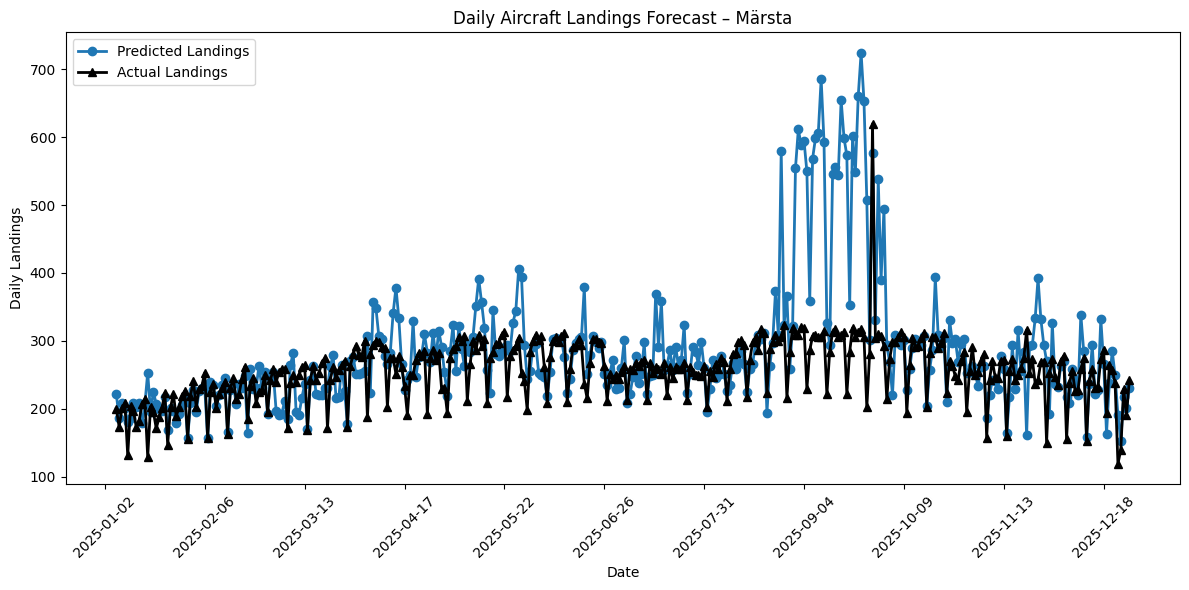

In [66]:
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.ticker import MultipleLocator
import pandas as pd

def plot_landing_forecast(city: str,
                          df: pd.DataFrame,
                          file_path: str,
                          hindcast=False):

    fig, ax1 = plt.subplots(figsize=(12, 6))

    day = pd.to_datetime(df['date'])

    # ---- Main axis: landings ----
    ax1.plot(day, df['predicted_landings'],
             label='Predicted Landings',
             color='tab:blue', linewidth=2, marker='o')

    if hindcast:
        ax1.plot(day, df['total_landings'],
                 label='Actual Landings',
                 color='black', linewidth=2, marker='^')

    ax1.set_ylabel('Daily Landings')
    ax1.set_xlabel('Date')
    ax1.set_title(f"Daily Aircraft Landings Forecast – {city}")
    ax1.legend(loc='upper left')

    # ---- X-axis density control ----
    if len(df) > 12:
        ax1.xaxis.set_major_locator(MultipleLocator(len(df) // 10))

    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(file_path)
    return plt
    
plot_landing_forecast("Märsta", df, "flight_weather_model/images", hindcast=True) 



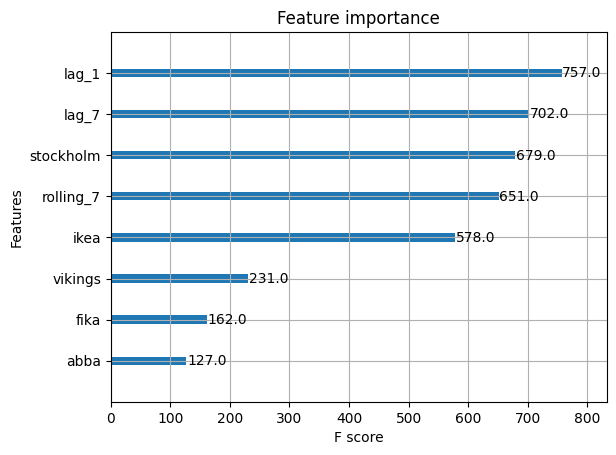

In [67]:
# Plotting feature importances using the plot_importance function from XGBoost
plot_importance(xgb_regressor)
feature_importance_path = images_dir + "/feature_importance.png"
plt.savefig(feature_importance_path)
plt.show()